In [1]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K

# ML4CVD Imports
sys.path.append("../ml4cvd")
from arguments import parse_args
from models import make_multimodal_to_multilabel_model, train_model_from_generators
from tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
def gradients_from_output(args, model, output_layer, output_index):
    K.set_learning_phase(1)
    input_tensor = model.input
    x = model.get_layer(output_layer).output[:,output_index]
    grads = K.gradients(x, input_tensor)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6) # normalization trick: we normalize the gradient
    iterate = K.function([input_tensor], [x, grads])
    return iterate

def saliency_map(input_tensor, model, output_layer, output_index):
    get_gradients = gradients_from_output(args, model, output_layer, output_index)
    activation, grads = get_gradients([input_tensor])
    print('Activation is:', activation, 'gradient shape:', grads.shape)
    return grads


In [68]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'end_systole_volume',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_esv.hd5',
            '--id', 'mri_slice_esv']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-07 18:53:03,816 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_esv/log_2019-05-07_18-53_0.log.
2019-05-07 18:53:03,818 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 3

2019-05-07 18:53:14,680 - tensor_generators:222 - INFO - Input tensor 'input_mri_slice' has shape (6, 256, 256, 1)
2019-05-07 18:53:14,681 - tensor_generators:225 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (6, 1)


(6, 256, 256, 1) (1, 256, 256, 1)


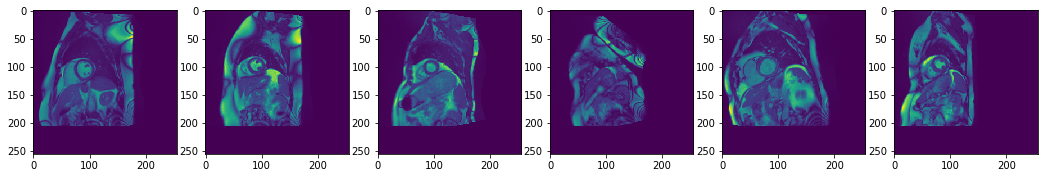

In [69]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [0.9951183  0.51997393 1.4880347  1.0317804  2.7989075  0.62294453] gradient shape: (6, 256, 256, 1)


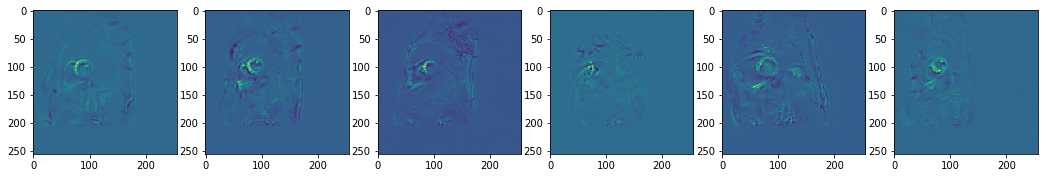

In [71]:
grads = saliency_map(test_tensor, model, 'output_end_systole_volume_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [52]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'bmi',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_bmi.hd5',
            '--id', 'mri_slice_bmi']

args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-07 18:44:39,586 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_bmi/log_2019-05-07_18-44_0.log.
2019-05-07 18:44:39,587 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 3

2019-05-07 18:44:52,308 - tensor_generators:222 - INFO - Input tensor 'input_mri_slice' has shape (6, 256, 256, 1)
2019-05-07 18:44:52,309 - tensor_generators:225 - INFO - Output tensor 'output_23104_Body-mass-index-BMI_0_0_continuous' has shape (6, 1)


(6, 256, 256, 1) (1, 256, 256, 1)


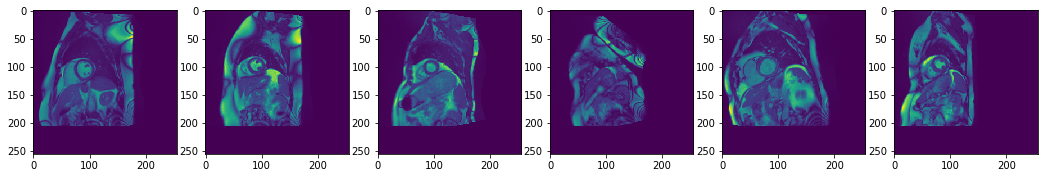

In [67]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [ 0.40508035 -0.17065036 -0.18296188 -0.33837095  0.45278993 -0.315191  ] gradient shape: (6, 256, 256, 1)


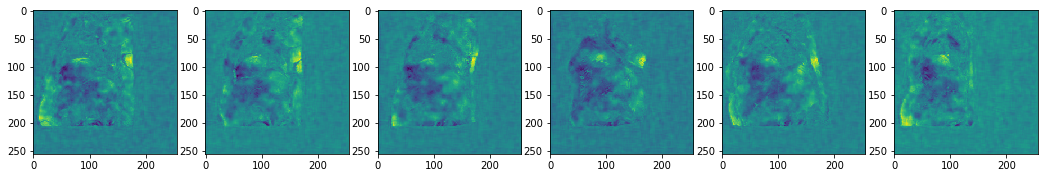

In [66]:
grads = saliency_map(test_tensor, model, 'output_23104_Body-mass-index-BMI_0_0_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [72]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_systole_diastole', 
            '--output_tensors', 'end_systole_volume',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_systole_diastole_esv.hd5',
            '--id', 'mri_systole_diastole_esv']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)



2019-05-07 18:55:58,121 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_systole_diastole_esv/log_2019-05-07_18-55_0.log.
2019-05-07 18:55:58,122 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 36

2019-05-07 18:56:04,794 - tensor_generators:222 - INFO - Input tensor 'input_mri_systole_diastole' has shape (6, 256, 256, 2, 1)
2019-05-07 18:56:04,795 - tensor_generators:225 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (6, 1)


(6, 256, 256, 2, 1) (1, 256, 256, 2, 1)


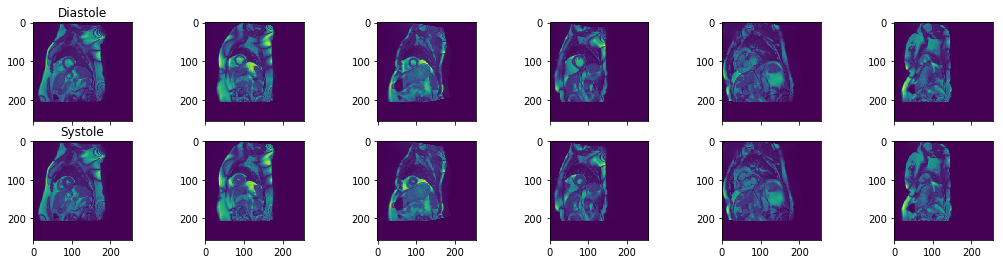

In [78]:
test_tensor = test_data['input_mri_systole_diastole']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(2, 6, figsize=(18, 4), sharex=True)
for i in range(6):
    axes[0, i].set_title('Diastole')
    axes[1, i].set_title('Systole')
    axes[0, i].imshow(test_tensor[i, :, :, 0, 0])
    axes[1, i].imshow(test_tensor[i, :, :, 1, 0])
    

Activation is: [0.64319247 0.70740354 1.5593781  0.23088326 1.8311199  0.2544826 ] gradient shape: (6, 256, 256, 2, 1)


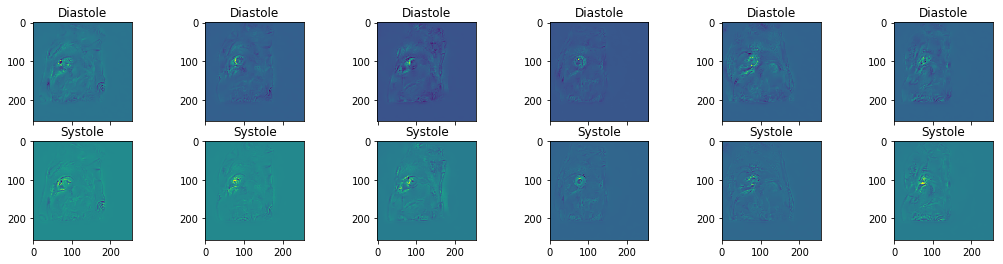

In [80]:
grads = saliency_map(test_tensor, model, 'output_end_systole_volume_continuous', 0)
_, axes = plt.subplots(2, 6, figsize=(18, 4), sharex=True)
for i in range(6):
    axes[0, i].set_title('Diastole')
    axes[1, i].set_title('Systole')
    axes[0, i].imshow(grads[i, :, :, 0, 0])
    axes[1, i].imshow(grads[i, :, :, 1, 0])
    

In [3]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-text3/2019-04-26/', 
            '--input_tensors', 'ecg_rest_1lead', 
            '--output_tensors', 'ecg_rhythm',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/home/sam/ml/trained_models/ecg_1lead_rhythm_only/ecg_1lead_rhythm_only.hd5',
            '--id', 'ecg_1lead_rhythm_only']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-07 19:28:42,519 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_1lead_rhythm_only/log_2019-05-07_19-28_0.log.
2019-05-07 19:28:42,520 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637,

2019-05-07 19:28:48,112 - tensor_generators:222 - INFO - Input tensor 'input_strip_ecg_rest' has shape (6, 600, 8)
2019-05-07 19:28:48,116 - tensor_generators:225 - INFO - Output tensor 'output_ecg_rhythm_categorical' has shape (6, 4)


(6, 600, 8) (1, 600, 8)


[[<matplotlib.lines.Line2D at 0x7f7a550fec50>],

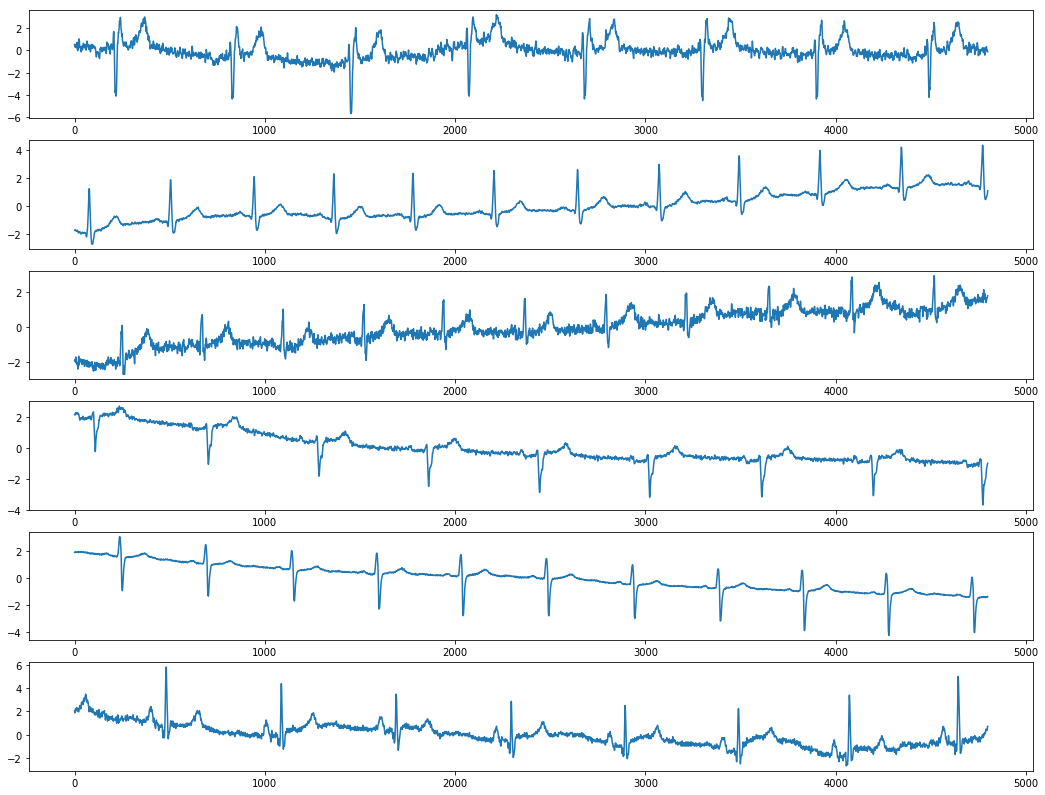

In [5]:
test_tensor = test_data['input_strip_ecg_rest']
print(test_tensor.shape, test_tensor[3:4].shape)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(test_tensor[i,:,:].flatten('F')) for i in range(6)]

Activation is: [9.7296975e-04 9.7824198e-01 9.5505023e-01 9.9894088e-03 9.8378527e-01
 2.1690167e-02] gradient shape: (6, 600, 8)


[[<matplotlib.lines.Line2D at 0x7f7a48e00390>],

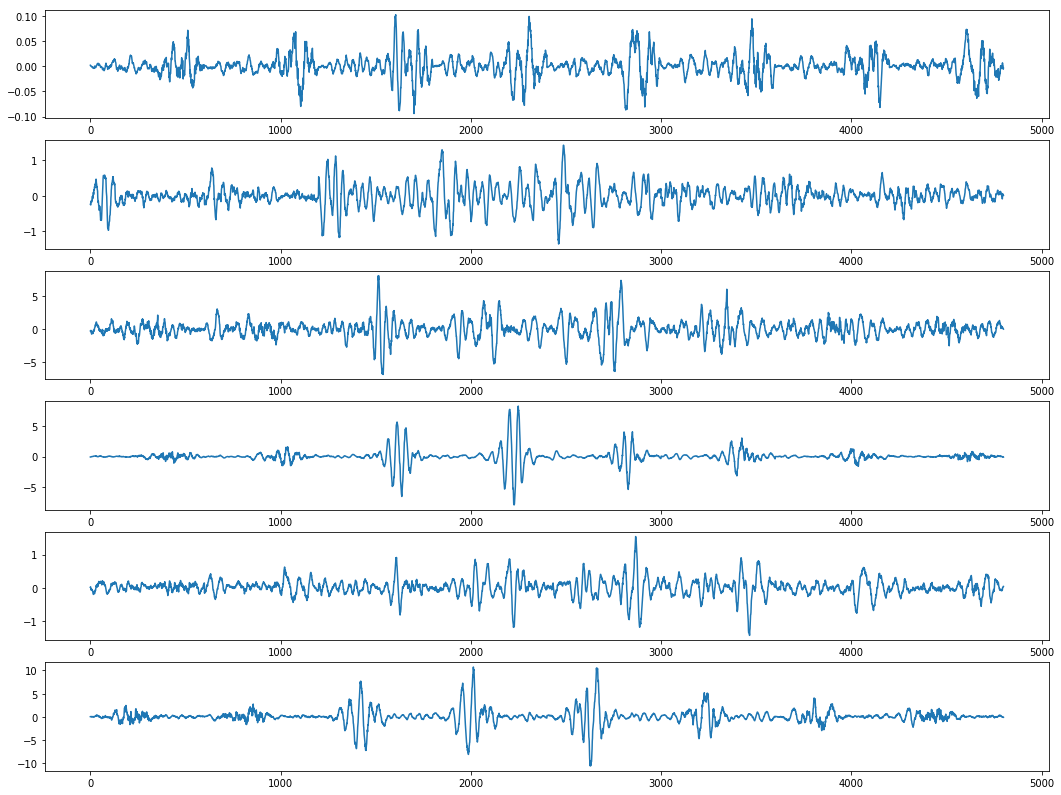

In [7]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 0)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(6)]

Activation is: [0.00015733 0.01020144 0.01954238 0.00030126 0.00532596 0.00048639] gradient shape: (6, 600, 8)


[[<matplotlib.lines.Line2D at 0x7f7a4881c198>],

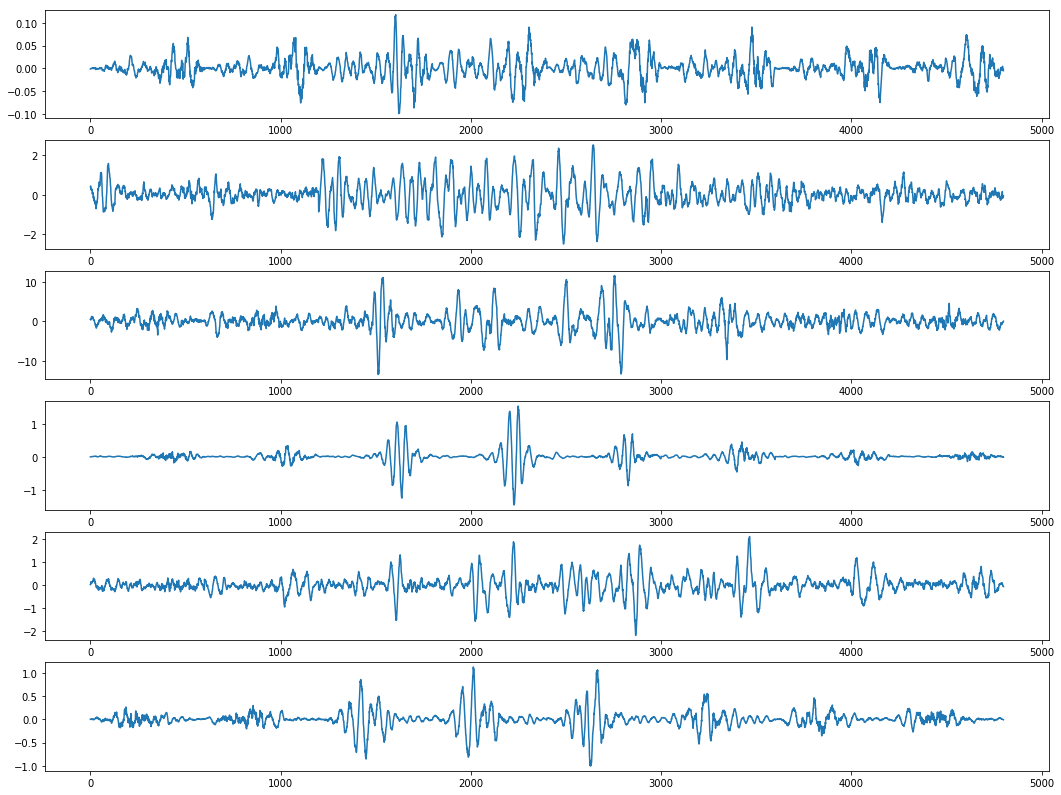

In [9]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 3)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(6)]

In [15]:
xdir = '/mnt/disks/ecg-text3/2019-04-26/'
paths = [xdir+'1238558.hd5', xdir+'1258475.hd5', xdir+'1286494.hd5', xdir+'1381627.hd5', 
         xdir+'1487911.hd5', xdir+'1509361.hd5', xdir+'1578315.hd5', xdir+'1616127.hd5', xdir+'1723645.hd5', ]
generator = TensorGenerator(8, args.tensor_maps_in, args.tensor_maps_out, paths, None, True)
data, labels, hd5s = next(generator)
print('predicitons are:', model.predict(data))

predicitons are: [[9.81849253e-01 9.10758507e-03 1.28329848e-03 7.75986956e-03]
 [7.19373465e-01 1.38788432e-01 4.79940511e-02 9.38440561e-02]
 [9.80298579e-01 1.33725079e-02 9.87614505e-04 5.34134591e-03]
 [2.38668080e-03 9.97361958e-01 2.30338803e-04 2.09874233e-05]
 [1.81672186e-01 7.01025665e-01 1.53886480e-02 1.01913497e-01]
 [9.54663515e-01 2.41942108e-02 2.13881256e-03 1.90034918e-02]
 [3.13027889e-01 6.16351143e-02 1.27190882e-02 6.12617910e-01]
 [1.29519880e-01 1.22165106e-01 1.24517739e-01 6.23797297e-01]]


[[<matplotlib.lines.Line2D at 0x7f7a3f63d898>],

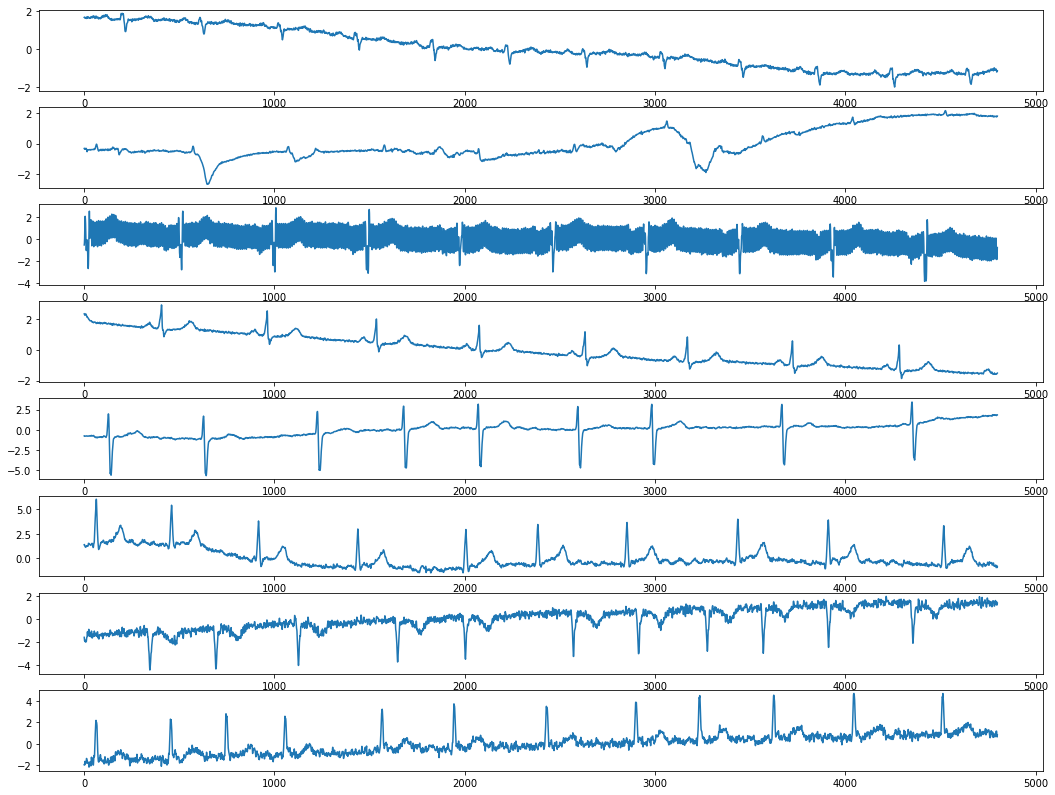

In [16]:
test_tensor = data['input_strip_ecg_rest']
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(test_tensor[i,:,:].flatten('F')) for i in range(8)]

Activation is: [7.7598696e-03 9.3844056e-02 5.3413459e-03 2.0987423e-05 1.0191350e-01
 1.9003492e-02 6.1261791e-01 6.2379730e-01] gradient shape: (8, 600, 8)


[[<matplotlib.lines.Line2D at 0x7f7a3f1b1d30>],

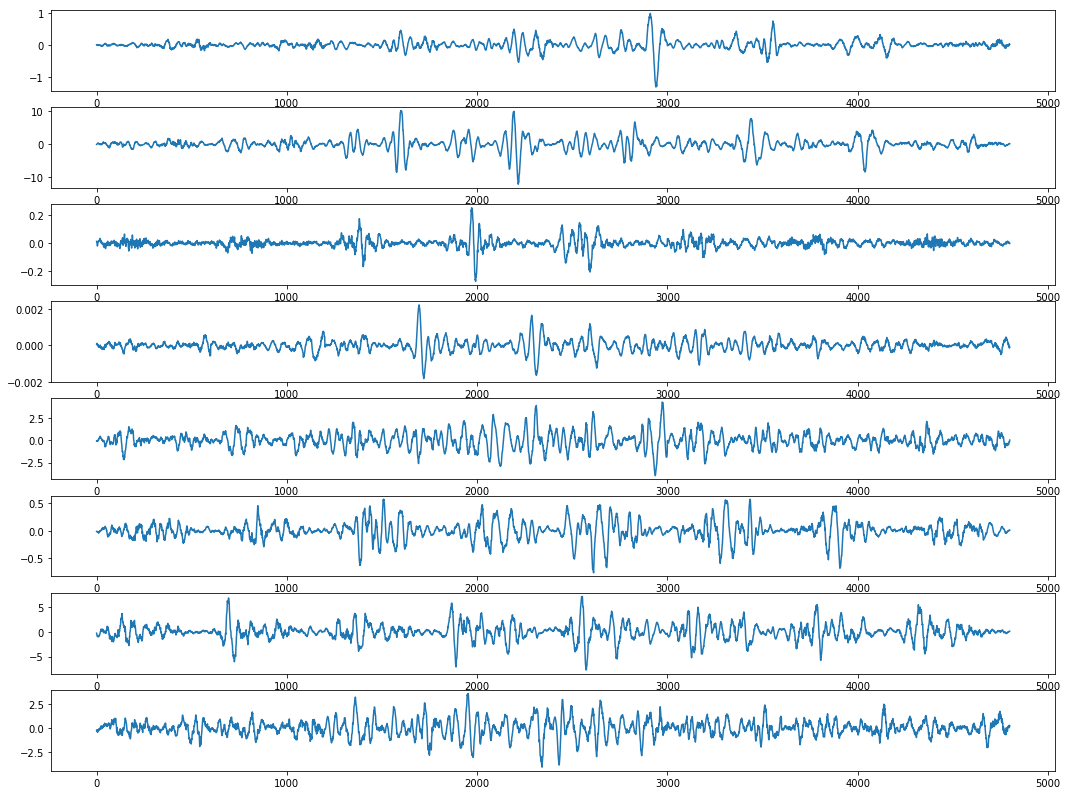

In [17]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 3)
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(8)]

Activation is: [0.98184925 0.71937346 0.9802986  0.00238668 0.18167219 0.9546635
 0.3130279  0.12951988] gradient shape: (8, 600, 8)


[[<matplotlib.lines.Line2D at 0x7f7a3ef2cac8>],

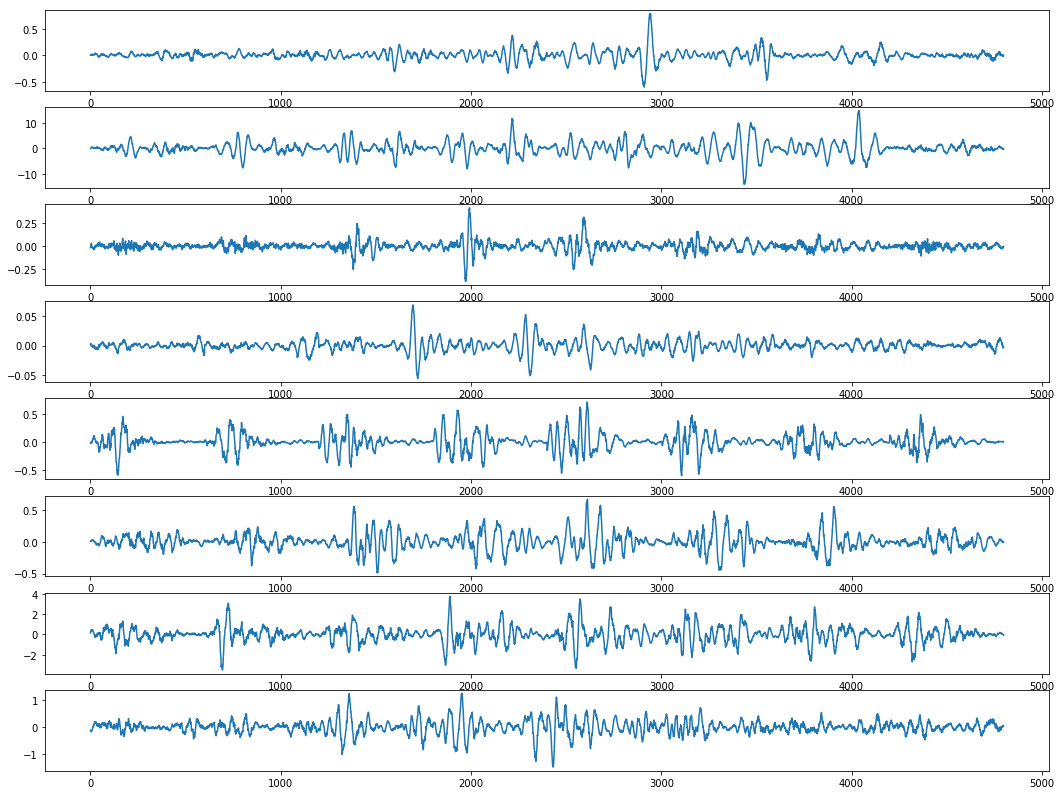

In [18]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 0)
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(8)]

Activation is: [0.01713828] gradient shape: (1, 600, 8)


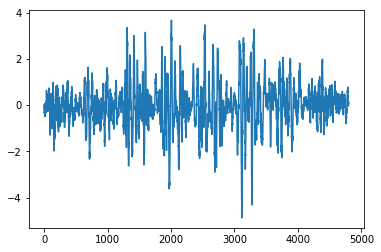

In [35]:
grads = saliency_map(test_tensor[7:8], model, 'output_ecg_rhythm_categorical', 2)

Activation is: [0.5469652] gradient shape: (1, 600, 8)


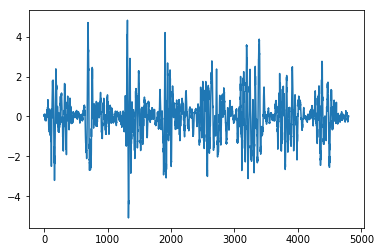

In [36]:
grads = saliency_map(test_tensor[7:8], model, 'output_ecg_rhythm_categorical', 0)